## Section 4: Deep Learning Model with PyTorch

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('ggplot')
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict

###################################################
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

########################################################
from fastai.collab import *  #fastai for COLLABorative filtering....
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.tabular import *

####################################################
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard import SummaryWriter


import io
import os
import math
import copy
import pickle
import zipfile
from tqdm import tqdm
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

from sklearn.decomposition import PCA

In [4]:
recsys_df = pd.read_csv('Olaleke_Tasks/RecSys_df.csv')
recsys_df.head()

,CardHolder,Material,SalesCount,ItemPrice,net_weight,SubCategorycode,ItemDescription,Class,rpa_wgh2,rpa_wgh2_SubClass,rpa_wgh3,rpa_wgh3_SubClass,vendor
0,10008254,109900,3.0,20.97,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
1,10011935,109900,1.0,6.49,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
2,10036221,109900,3.0,19.47,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
3,10036221,109900,2.0,12.98,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
4,10036221,109900,4.0,25.96,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0


In [4]:
No_lentabag_df = pd.read_csv('Olaleke_Tasks/No_lentabag.csv')
No_lentabag_df.head()

,CardHolder,Material,SalesCount,ItemPrice,net_weight,SubCategorycode,ItemDescription,Class,rpa_wgh2,rpa_wgh2_SubClass,rpa_wgh3,rpa_wgh3_SubClass,vendor
0,10008254,439630,1.0,169.99,500.0,420103,Dry dog food up to 800 gr,FOOD,42.0,Pet goods,4201.0,Goods for dogs,100410.0
1,14919617,439630,1.0,109.89,500.0,420103,Dry dog food up to 800 gr,FOOD,42.0,Pet goods,4201.0,Goods for dogs,100410.0
2,15041309,439630,1.0,169.99,500.0,420103,Dry dog food up to 800 gr,FOOD,42.0,Pet goods,4201.0,Goods for dogs,100410.0
3,15041309,439630,1.0,116.99,500.0,420103,Dry dog food up to 800 gr,FOOD,42.0,Pet goods,4201.0,Goods for dogs,100410.0
4,15041309,439630,1.0,152.14,500.0,420103,Dry dog food up to 800 gr,FOOD,42.0,Pet goods,4201.0,Goods for dogs,100410.0


In [6]:
user_item_df = pd.read_csv('Olaleke_Tasks/user_item_nonbag.csv')
user_item_df.head()

,CardHolder,Material,SalesCount
0,10008254,4135,2.0
1,10008254,5383,2.0
2,10008254,5880,2.0
3,10008254,78790,2.0
4,10008254,81107,1.0


In [5]:
item_lookup = pd.read_csv('Olaleke_Tasks/item_lookup_nonbag.csv')
item_lookup.head()

,Material,ItemDescription
0,439630,Dry dog food up to 800 gr
1,338329,Dry dog food up to 800 gr
2,338283,Dry dog food up to 800 gr
3,338287,Dry dog food up to 800 gr
4,513215,Dry dog food up to 800 gr


In [73]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)
        
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)        

def create_dataset(quantities, top=None):
    if top is not None:
        user_item_df.groupby('CardHolder')['SalesCount'].count()
    
    unique_users = user_item_df.CardHolder.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = user_item_df.CardHolder.map(user_to_index)
    
    unique_items = user_item_df.Material.unique()
    items_to_index = {old: new for new, old in enumerate(unique_items)}
    new_items = user_item_df.Material.map(items_to_index)
    
    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'item_id': new_items})
    y = user_item_df['SalesCount'].astype(np.float32)
    return (n_users, n_items), (X, y), (user_to_index, items_to_index)

In [71]:
(n, m), (X, y), _ = create_dataset(user_item_df)
print(f'Embeddings: {n} users, {m} items')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 86497 users, 58320 items
Dataset shape: (15205494, 2)
Target shape: (15205494,)


In [68]:

class getIterator:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]
    
    

def batches(X, y, bs=32, shuffle=True):
    for xb, yb in getIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)    

In [65]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[75435, 50446],
        [58263,  5345],
        [75165, 11199],
        [72031, 13105]])
tensor([[5.],
        [6.],
        [1.],
        [2.]])


In [66]:
class EmbeddingNet(nn.Module):
    
    def __init__(self, n_users, n_items,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_items, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, items, minmax=None):
        features = torch.cat([self.u(users), self.m(items)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_qqt, max_qqt = minmax
            out = out*(max_qqt - min_qqt + 1) + min_qqt - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')


In [46]:
class CyclicLR(_LRScheduler):  
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)
    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
    
def triangular(step_size, max_lr, method='triangular', gamma=0.99):  
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass 
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
        return base_lr + delta
    return scheduler  


def cosine(t_max, eta_min=0):
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    return scheduler

In [47]:

def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [49]:
dataset_sizes

{'train': 12164395, 'val': 3041099}

In [329]:
#datasets['train']

In [50]:
minmax = user_item_df.SalesCount.min(),user_item_df.SalesCount.max()
minmax

(0.002, 23055.0)

In [51]:
net = EmbeddingNet(
    n_users=n, n_items=m, 
    n_factors=150, hidden=[100, 200, 300], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])
net

EmbeddingNet(
  (u): Embedding(86497, 150)
  (m): Embedding(58320, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [75]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 10
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))


for epoch in tqdm(range(n_epochs)):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and quantities when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break


 10%|█         | 1/10 [49:05<7:21:52, 2945.78s/it]

loss improvement on epoch: 1
[001/010] train: 167859.1286 - val: 62.1597


 20%|██        | 2/10 [1:29:19<6:11:28, 2786.03s/it]

loss improvement on epoch: 2
[002/010] train: 105.6802 - val: 57.2984


 30%|███       | 3/10 [2:02:40<4:57:35, 2550.79s/it]

loss improvement on epoch: 3
[003/010] train: 103.5383 - val: 55.4489


 40%|████      | 4/10 [2:36:16<3:59:01, 2390.28s/it]

loss improvement on epoch: 4
[004/010] train: 101.5359 - val: 52.5663


 50%|█████     | 5/10 [3:11:51<3:12:47, 2313.57s/it]

loss improvement on epoch: 5
[005/010] train: 99.2298 - val: 49.6233


 60%|██████    | 6/10 [3:47:42<2:30:58, 2264.72s/it]

loss improvement on epoch: 6
[006/010] train: 95.2699 - val: 47.1074


 70%|███████   | 7/10 [4:23:56<1:51:52, 2237.51s/it]

[007/010] train: 95.4373 - val: 47.9265


 80%|████████  | 8/10 [4:59:54<1:13:47, 2213.88s/it]

loss improvement on epoch: 8
[008/010] train: 92.5364 - val: 46.2087


 90%|█████████ | 9/10 [5:34:10<36:06, 2166.50s/it]  

[009/010] train: 94.2564 - val: 48.0857


100%|██████████| 10/10 [6:08:25<00:00, 2210.55s/it]

[010/010] train: 91.5357 - val: 46.3940


In [28]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[21646,  1184],
        [81410,   811],
        [25586,  7662],
        [12293,  4868]])
tensor([[1.0000],
        [0.0600],
        [6.0000],
        [1.1000]])


In [76]:
torch.save(net.state_dict(),'EmbNet2.pth')

In [281]:
#ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

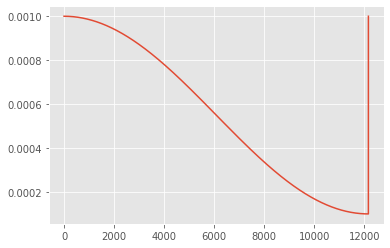

In [77]:

_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [78]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [80]:
net.load_state_dict(torch.load('EmbNet2.pth',map_location='cpu'))

<All keys matched successfully>

In [81]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [82]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 6.8044


In [83]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

## Model Interpretation 


-  The embedding are low dimensional representation for users and items, 


- The embeddings learned represents the style and kind of items and users


-  these representation contains interesting features which we can extract and visualize


- the item biases and weights can be extracted;


- this will give insights of what items should be ranked lower or higher using the embedding bias.

-  and the embedding weights tells how similar some of the most popular items are

In [84]:
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

<All keys matched successfully>

In [85]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [86]:
#user_item_df

In [87]:
_, _, (user_id_map, item_id_map) = create_dataset(user_item_df)
embed_to_original = {v: k for k, v in item_id_map.items()}
popular_items = user_item_df.groupby('Material').Material.count().sort_values(ascending=False).values[:1000]

In [88]:
embed = to_numpy(net.u.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_items].T).components_
components.shape

(5, 1000)

In [89]:
print(net.u)
print(net.m)

Embedding(86497, 150)
Embedding(58320, 150)


In [90]:
item_lookup.head()

,Material,ItemDescription
0,439630,Dry dog food up to 800 gr
1,338329,Dry dog food up to 800 gr
2,338283,Dry dog food up to 800 gr
3,338287,Dry dog food up to 800 gr
4,513215,Dry dog food up to 800 gr


In [91]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
items_ids = [embed_to_original[idx] for idx in components_df.index]
meta = item_lookup.set_index('Material')
components_df['Material'] = items_ids

In [92]:
components_df['ItemDescription'] = meta.loc[items_ids].ItemDescription.values


In [93]:
components_df.sample(4)

,fc0,fc1,fc2,fc3,fc4,Material,ItemDescription
979,0.034897,-0.076441,-0.011245,-0.037367,0.013336,351102,Sparkling rose and red wine
883,0.065448,-0.039855,0.019259,0.008017,-0.067489,293464,Men's deodorant spray
787,0.053048,-0.000631,-0.007767,0.002538,0.006821,232231,Individual portion food (pouch)
716,0.002990,0.000634,-0.020528,0.017733,-0.031908,175019,Mixes and universal seasoning


In [94]:
#components_df.to_csv('item_pca_components.csv',index=False)

In [95]:
#comp = pd.read_csv('item_pca_components.csv')

In [96]:
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [97]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    #titles = ['\n'.join(wrap(t, width=10)) for t in subset.title]
    labels = ['\n'.join(wrap(t, width=10)) for t in subset.ItemDescription]
    #genres = subset.genres.str.replace('|', '\n')
    #labels = [f'{t}\n\n{g}' for t, g in zip(titles, genres)]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=60, fontsize=12)
    ax.set_yticklabels(y_ticks, fontsize=12)
    ax.legend(loc='best', fontsize=12)
    
    plot_title = f"Items with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

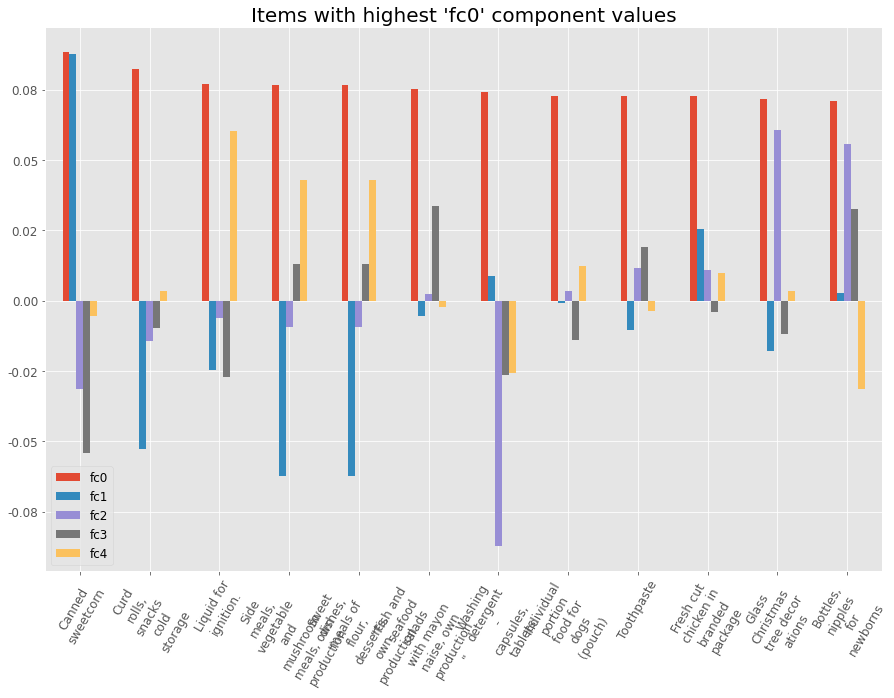

In [98]:
plot_components(components_df, 'fc0', ascending=False)

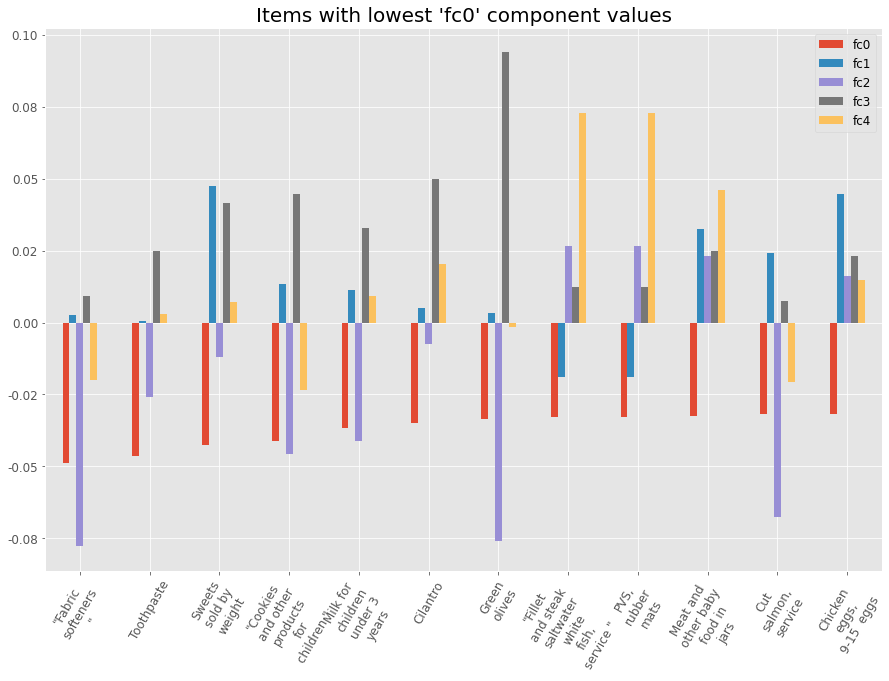

In [99]:
plot_components(components_df, 'fc0', ascending=True)

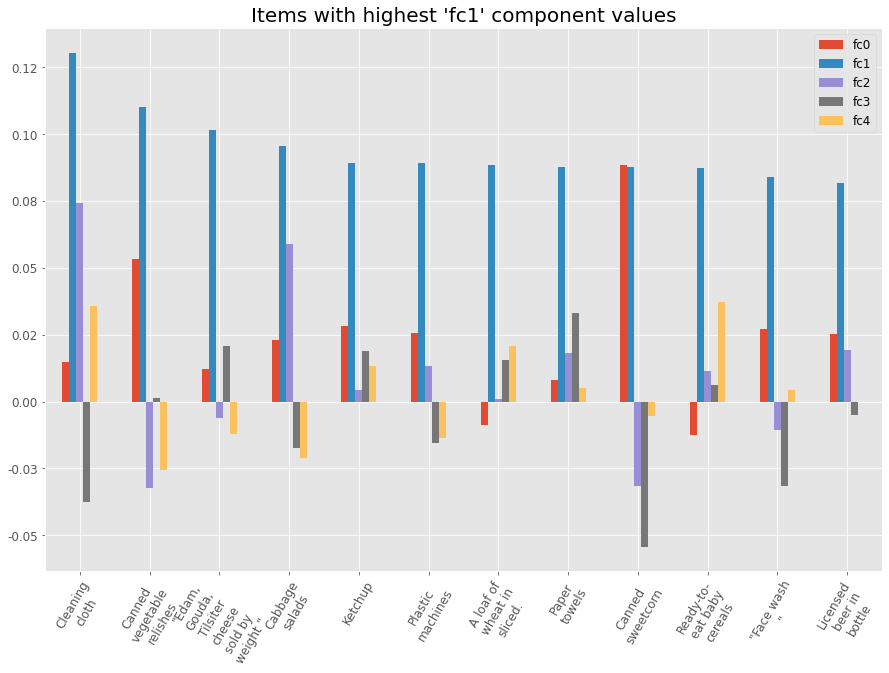

In [100]:
plot_components(components_df, 'fc1', ascending=False)

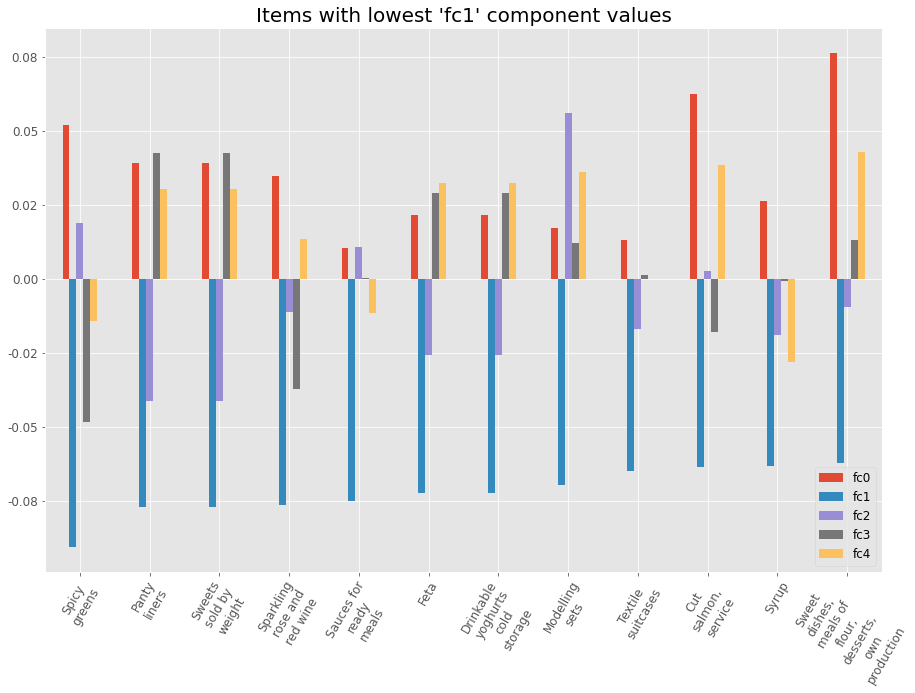

In [103]:
plot_components(components_df, 'fc1', ascending=True)

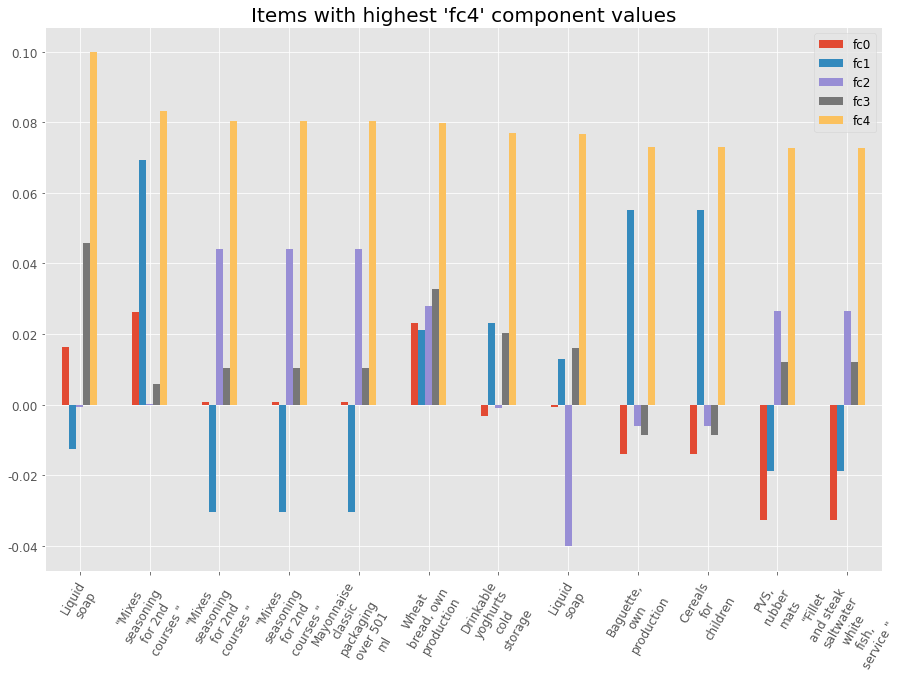

In [104]:
plot_components(components_df, 'fc4', ascending=False)

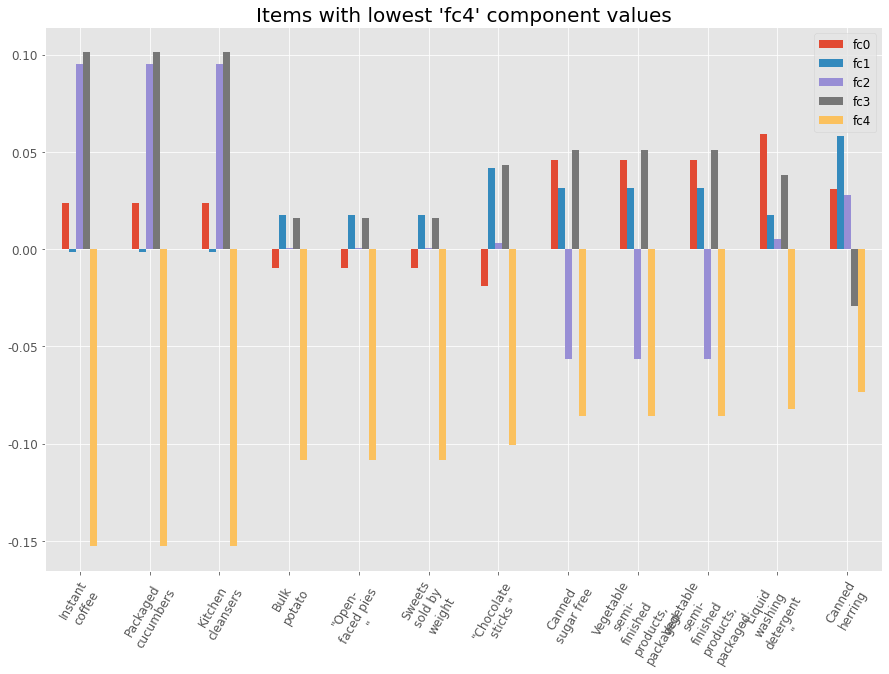

In [105]:
plot_components(components_df, 'fc4', ascending=True)

- The fastai library provides many useful functions that enable us 


- to quickly and easily build neural networks and train our models.

- FastAI provides two different types of collab models.


   -  A simple model called **EmbeddingDotBias**: which creates embeddings for both users and items and then takes the dot product of them.
   
   
  - The second is a neural network based model **EmbeddingN Model** which uses embeddings and fully-connected layers.


  - Both models can be created using the collab_learner class.


  - the **use_nn** argument is set to falseto use the EmbeddingDotBias model.

In [6]:
              #creating databunch using collabDataBunch -- 
              #Databunch  for collaborative filtering
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data  = CollabDataBunch.from_df(user_item_df, 
                                valid_pct =0.2,     #reserve separate 20% for validation...
                                user_name = 'CardHolder',
                                item_name = 'Material',
                                rating_name = 'SalesCount',
                                device = device,
                                seed = 42)

data

TabularDataBunch;

Train: LabelList (12274427 items)
x: CollabList
CardHolder 10008254; Material 4135; ,CardHolder 10008254; Material 5383; ,CardHolder 10008254; Material 78790; ,CardHolder 10008254; Material 81107; ,CardHolder 10008254; Material 109900; 
y: FloatList
2.0,2.0,2.0,1.0,3.0
Path: .;

Valid: LabelList (3068606 items)
x: CollabList
CardHolder 48076760; Material 351730; ,CardHolder 58216051; Material 275345; ,CardHolder 82785948; Material 427321; ,CardHolder 82909267; Material 189388; ,CardHolder 56758256; Material 515143; 
y: FloatList
0.418,2.0,0.09,0.614,4.0
Path: .;

Test: None

In [7]:
        #displacing a batch from the data..
data.show_batch()

CardHolder,Material,target
60256084,388277,8.0
59048364,375247,0.192
59456629,163851,1.0
82732798,183054,1.0
43521582,303640,1.352


In [8]:
min_qty =  user_item_df.SalesCount.min()
max_qty = user_item_df.SalesCount.max()

print('Minimum Quantity: ',min_qty)
print('Minimum Quantity: ',max_qty)

Minimum Quantity:  0.002
Minimum Quantity:  31382.0


### EmbeddingNN Model

In [10]:
          #Creating collaborative filtering EmbeddingNN model learner with fastAI
NN_learner = collab_learner(data,
                            use_nn  = True,
                            emb_szs = {'CardHolder':40,'Material':40},
                            layers = [256,128,64,32],
                            y_range = (min_qty,max_qty)
                            )

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


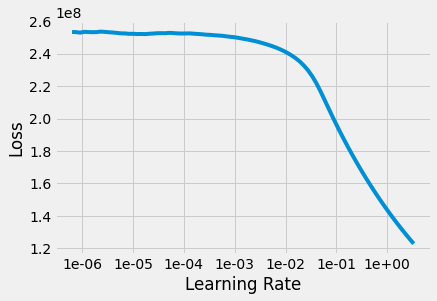

In [11]:
NN_learner.lr_find()            #finding learning rate
NN_learner.recorder.plot()      #plotting the lerarning rate

In [ ]:
NN_learner.fit_one_cycle(5,1e-2)   #choice of learning rate 1e-2, and training with epochs = 5

epoch,train_loss,valid_loss,time
0,59.977730,1348993.375000,2:55:41


In [ ]:
              #unfreezing the modle to train all the layers...
NN_learner.unfreeze()
NN_learner.fit_one_cycle(2,1e-2)

In [ ]:
        #saving the model..
#NN_learner.save('RecSys_fastai_1')

In [ ]:
#NN_learner.load('RecSys_fastai_1')

## EmbeddingDOTBias Model

In [15]:
DB_learner = collab_learner(data, 
                            n_factors=40,
                            y_range = (min_qty,max_qty),
                            wd = 1e-1 )

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


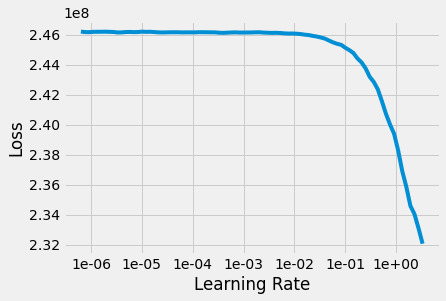

In [16]:
DB_learner.lr_find()
DB_learner.recorder.plot()

In [17]:
DB_learner.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,time
0,48703240.000000,48164828.000000,3:43:25


In [18]:
              #unfreezing the model to train all the layers...
DB_learner.unfreeze()
DB_learner.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,time
0,48495196.000000,48234676.000000,4:12:39


In [19]:
DB_learner.save('DotBiasModel')

In [114]:
DB_learner.load('DotBiasModel')

CollabLearner(data=TabularDataBunch;

Train: LabelList (12274427 items)
x: CollabList
CardHolder 10008254; Material 4135; ,CardHolder 10008254; Material 5383; ,CardHolder 10008254; Material 78790; ,CardHolder 10008254; Material 81107; ,CardHolder 10008254; Material 109900; 
y: FloatList
2.0,2.0,2.0,1.0,3.0
Path: .;

Valid: LabelList (3068606 items)
x: CollabList
CardHolder 48076760; Material 351730; ,CardHolder 58216051; Material 275345; ,CardHolder 82785948; Material 427321; ,CardHolder 82909267; Material 189388; ,CardHolder 56758256; Material 515143; 
y: FloatList
0.418,2.0,0.09,0.614,4.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(86237, 40)
  (i_weight): Embedding(58123, 40)
  (u_bias): Embedding(86237, 1)
  (i_bias): Embedding(58123, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models',

In [67]:
#                                     ##get most popular items based on mean  quantities...
#                                     #mean rating.....
# most_pop = user_item_df.groupby(['Material'])['SalesCount'].mean().sort_values(ascending=False).head(20)
# df1 = pd.DataFrame(most_pop)
# df1 = df1.rename(columns={'SalesCount':'Mean_Quantity'})
# #df1

# pop_list = most_pop.index.to_list()
# pop_dff = item_lookup.loc[item_lookup['Material'].isin(pop_list)]
# #pop_dff

#                 #merging
# dff =pd.merge(pop_dff,df1 , on='Material')
# dff.sort_values('Mean_Quantity',ascending=False, inplace=True)

# dff



#                                   ##getting most popular items by item quantities...
    
# top_counts = user_item_df.groupby(['Material'])['SalesCount'].count().sort_values(ascending=False).head(20)
# #top_counts    
# top_counts_df = pd.DataFrame(top_counts)
# top_counts_df = top_counts_df.rename(columns={'SalesCount':'Quantity'})

# top_list = top_counts.index.to_list()
# top_dff = item_lookup.loc[item_lookup['Material'].isin(top_list)]

#                 #merging
# top_list_df =pd.merge(top_dff,top_counts_df, on='Material')
# top_list_df.sort_values('Quantity',ascending=False, inplace=True)
# top_list_df